## Analyzing inference error for small model

In [1]:
%reload_ext autoreload
%autoreload 2
# General modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling

# Import RCA module
import RCAmodule as rca

### Define 5LayerModel

{'A1': {'Position': (0, -1), 'Type': 'cause', 'VarType': 'binary'},
 'A2': {'Position': (0, -2), 'Type': 'cause', 'VarType': 'binary'},
 'B1': {'Position': (1, -1), 'Type': 'cause', 'VarType': 'binary'},
 'F1': {'Position': (2, -1), 'Type': 'fault', 'VarType': 'binary'},
 'F2': {'Position': (2, -2), 'Type': 'fault', 'VarType': 'binary'},
 'M1': {'Position': (0, 1), 'Type': 'measurement', 'VarType': 'binary'},
 'M2': {'Position': (1, 1), 'Type': 'measurement', 'VarType': 'binary'}}

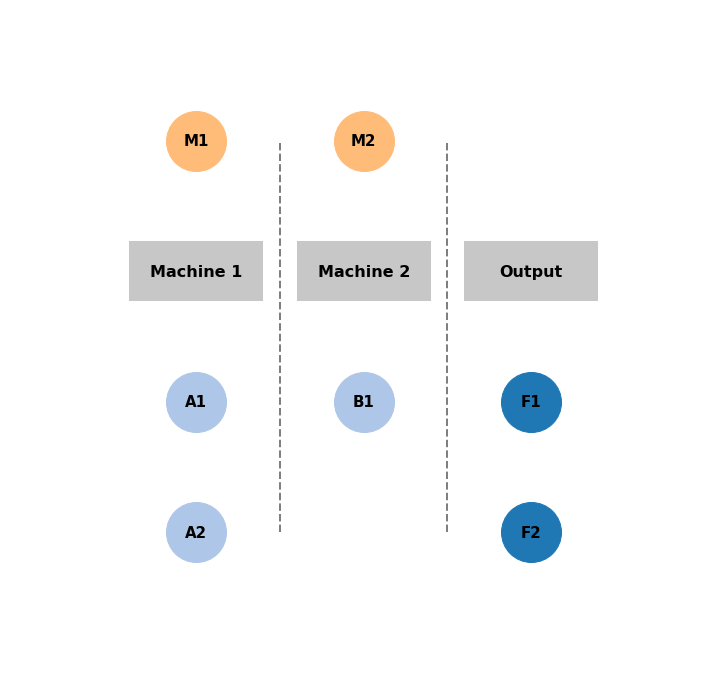

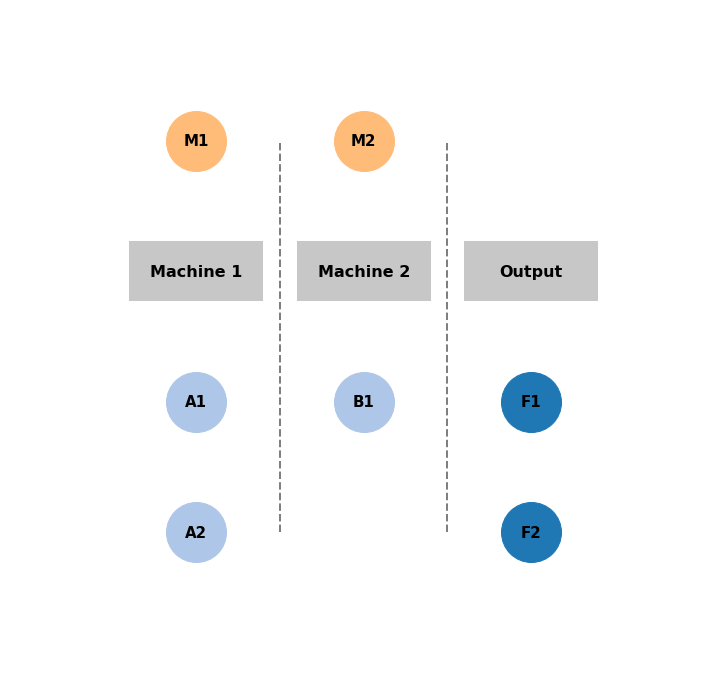

In [4]:
# With measurement nodes
process1 = [{'Name': 'Machine 1', 
            'Nodes': [('A1', 'cause', 'binary'), 
                      ('A2', 'cause', 'binary'),
                      ('M1', 'measurement', 'binary')]},
           
           {'Name': 'Machine 2', 
            'Nodes': [('B1', 'cause', 'binary'),
                      ('M2', 'measurement', 'binary')]},
           
           {'Name': 'Output', 
            'Nodes': [('F1', 'fault', 'binary'), 
                      ('F2', 'fault', 'binary')]}
         ]

# Without measurement nodes
process2 = [{'Name': 'Machine 1', 
            'Nodes': [('A1', 'cause', 'binary'), 
                      ('A2', 'cause', 'binary')]},
           
           {'Name': 'Machine 2', 
            'Nodes': [('B1', 'cause', 'binary')]},
           
           {'Name': 'Output', 
            'Nodes': [('F1', 'fault', 'binary'), 
                      ('F2', 'fault', 'binary')]}
         ]
# Create RCAmocel
P = rca.RCAModel(process1)

# Plot problem
#P.plotProcess(figname='rca_network_small.png')
P.plotProcess(figsize=(12,12), figname='small_network_M_nodes.png')

for edge in mod.edges():
    P.model.add_edge(edge[0],edge[1])

P.plotProcess(figsize=(12,12), figname='small_network_M_nodes_edges.png')

#### Load data

In [4]:
data              =  pickle.load(open("samples_Example3.pkl", "rb"))
data = data.drop(['F3'], axis=1)
columns_without_M =  data.columns[2:len(data.columns)]
data_without_M    =  data[columns_without_M]
print(data.columns)

FileNotFoundError: [Errno 2] No such file or directory: 'samples_Example3.pkl'

## Error estimates!

# Create model w exact values to compute inference error

In [3]:
mod = BayesianModel([('A1', 'F1'),
                     ('A2', 'B1'),
                     ('A2', 'F1'),
                     ('A2', 'F2'),
                     ('B1', 'F2'),
                     ('A1', 'M1'),
                     ('B1', 'M2'),
                     ])
# Add a node which has no edges
#mod.add_node('F3')

# Create conditional probability distribution for 'A1' node
cpd_A1 = TabularCPD(variable='A1', 
                    variable_card=2, 
                    values=[[0.95, 0.3],
                            [0.05, 0.7]],
                    evidence = ['M1'],
                    evidence_card = [2])

# Create conditional probability distribution for 'A2' node 
cpd_A2 = TabularCPD(variable='A2', 
                    variable_card=2, 
                    values=[[0.85, 0.15]])
  

# Create conditional probability distribution for 'B1' node 
cpd_B1 = TabularCPD(variable='B1', 
                    variable_card=2, 
                    values=[[0.75, 0.03, 0.3, 0.01], 
                            [0.25, 0.97, 0.7, 0.99]],
                    evidence = ['A2', 'M2'],
                    evidence_card = [2, 2])


# Create conditional probability distribution for 'F1' node
cpd_F1 = TabularCPD(variable='F1', 
                    variable_card=2, 
                    values=[[0.95, 0.8, 0.3, 0.1], 
                            [0.05, 0.2, 0.7, 0.9]],
                    evidence = ['A1', 'A2'],
                    evidence_card = [2, 2])
                     
# Create conditional probability distribution for 'F2' node 
cpd_F2 = TabularCPD(variable='F2', 
                    variable_card=2, 
                    values=[[1.0, 0.3, 0.85, 0.01], 
                            [0.0, 0.7, 0.15, 0.99]], 
                    evidence = ['A2', 'B1'],
                    evidence_card = [2, 2])

# Create conditional probability distribution for 'F3' node 
#cpd_F3 = TabularCPD(variable='F3', variable_card=2, values=[[0.90, 0.10],
                                                           #[0.10, 0.90]], evidence=['A1'], evidence_card=[2])

# Create conditional probability distribution for 'M1' node 
cpd_M1 = TabularCPD(variable='M1', variable_card=2, values=[[0.75, 0.25]])

# Create conditional probability distribution for 'M2' node 
cpd_M2 = TabularCPD(variable='M2', variable_card=2, values=[[0.90, 0.10]])

# Add cpds to model
mod.add_cpds(cpd_A1, cpd_A2, cpd_B1, cpd_F1, cpd_F2, cpd_M1, cpd_M2)

In [ ]:
#def computeTrainingError(model_trained, method = 'values', model_true = None, data_true = None):
#    # Use some kind of mean sqaure error
#    if method is 'values':
#        if model_true:
#            # create lists
#            trained_model_cpds = cpdsToList(model_trained.cpds)
#            true_model_cpds    = cpdsToList(model_true.cpds)
#            avg_difference = np.sum([np.abs(val1-val2) for val1,val2 in zip(trained_model_cpds, true_model_cpds)])
#            training_error = avg_difference/len(trained_model_cpds)
#        else:
#            pass
#    else:
#        pass
    
#    return training_error

In [14]:
from pgmpy.inference import VariableElimination


def computeInferenceError(model_trained, model_true, infer_type, nodes, evidence_true, evidence_trained, method):
    # Inference trained model
    #inferred_trained = P.inference(method, nodes, evidence)
    # Inference true model
    if method is 'varelim':
        model_true_infer       =  VariableElimination(model_true)
        model_trained_infer    =  VariableElimination(model_trained)
        if infer_type is 'conditional':
            # Conditional distribution query
            inferred_true           =  model_true_infer.query(nodes, evidence_true)
            inferred_trained        =  model_trained_infer.query(nodes, evidence_trained)
            # MOVED THIS PART INSIDE 'if'
            inferred_true_flat    = inferenceFlatten(inferred_true, nodes) # Make list
            inferred_trained_flat = inferenceFlatten(inferred_trained, nodes)
            inferenceError = np.sqrt(np.sum(np.abs(np.subtract(inferred_true_flat, inferred_trained_flat))**2))
 
        else: # map_query
            inferred_true           =  model_true_infer.map_query(nodes, evidence_true) # most proabable assignment, new!
            inferred_trained        =  model_trained_infer.map_query(nodes, evidence_trained)
            inferred_true_flat = [inferred_true[node] for node in nodes]
            inferred_trained_flat = [inferred_true[node] for node in nodes]
        #l2 norm
            inferenceError = [inferred_true_flat, inferred_trained_flat]
        return inferenceError
    else:
        pass

## Flatten cpds

In [ ]:
#plt.plot(sampleSizes,inferenceError);
#print(P.model.cpds)
def cpdsToList(model_cpds):
# "flatten" cpds
    cpds_in_list = []
    for cpd in model_cpds:
        for val in cpd.values:
            if type(val)==np.ndarray:
                if type(val[0])==np.float64:
                    for vals in val:
                        cpds_in_list.append(vals)
                else:
                    for vals in val[0]:
                        cpds_in_list.append(vals)
            else:
                cpds_in_list.append(val)
    return cpds_in_list

# Inference error

## Nbr of corret edges found 

In [49]:
numIterations   = 40  # Start with few
numIncrements = 100
# Increments
sampleDifference = 300 


testSet        =  data.sample(1000) # Sample from dataframe
remaingData_indices = [ind for ind in data.index if not ind in testSet.index ]
remainingData   =  pd.DataFrame(data.values[remaingData_indices], columns = data.columns)
edgesFound      = []

# Save number of correct edges
numberOfCorrectEdges = np.zeros([numIterations, numIncrements])
sampleSizes          = [(i + 1) * sampleDifference for i in range(numIncrements)]
expert_edges =[('A2', 'B1'),('A2', 'F1'),('B1', 'F2')]
for i in range(numIterations):
    for j in range(numIncrements):
        # New model each time
        P = rca.RCAModel(process1)
        # Number of samples
        numSamples = (j + 1) * sampleDifference 
        # Sample size increments
        #sampleSizes[i] = numSamples
        # Sample from dataframe without testSet
        trainingSet = remainingData.sample(numSamples)
        # Structure learning, constraintbased
        P.structureLearning(trainingSet,'constraintbased',expert_edges)
        edgesFound.append(P.model.edges())
        # Check number of edges, we count reverse edges as well! See code in RCAmodule.
        nbrEdges = [i+1 for i, edge in zip(range(len(P.model.edges())),P.model.edges()) if (edge[0], edge[1]) in mod.edges() or (edge[1], edge[0]) in mod.edges()]                                               #len(P.model.edges())
        numberOfCorrectEdges[i][j] = nbrEdges[len(nbrEdges)-1]

C:\Users\lokrantz\Documents\Code\Git repositories, Python\RCA\RCA\lab\pgmpy\estimators\ConstraintBasedEstimator.py:326: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  "oriented arbitrarily.")


In [53]:
np.savetxt('average_edges_small_new_expert.txt', numberOfCorrectEdges, fmt='%d')

In [54]:
np.savetxt('edgesFound_expert.txt', edgesFound, fmt='%s')
P.model.edges()

[('A1', 'F1'),
 ('A1', 'M1'),
 ('A2', 'F2'),
 ('A2', 'B1'),
 ('A2', 'F1'),
 ('B1', 'F2')]

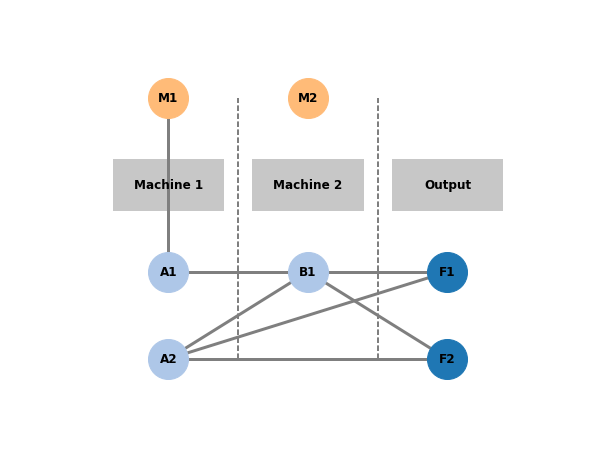

In [55]:
P.plotProcess(plotEdges=True)

## Latest tasks

In [16]:
def inferenceFlatten(inferred, nodes):
    #inferred_trained = P.inference(method,nodes,evidence)
    cpds_in_list     = []
    for node in nodes:
        if type(inferred[node].values[0])==np.float64:
            for val in inferred[node].values:
                cpds_in_list.append(val)
        elif type(inferred[node].values[0])== np.ndarray:
            for arr in inferred[node].values:
                for val in arr:
                    cpds_in_list.append(val)
    return cpds_in_list

## Structure and parameter learning all M and F

In [17]:
from numpy.random import randint
import time
tic = time.clock()

numIterations    = 100  
numCombinations  = 40

sampleDifference = 300 

testSet        =  data.sample(1000) # Sample from dataframe
remaingData_indices = [ind for ind in data.index if not ind in testSet.index ]
remainigData   =  pd.DataFrame(data.values[remaingData_indices], columns = data.columns)
inferenceError0 =  np.zeros([numCombinations, numIterations]) # Initialize

sampleSizes    =  np.zeros(numIterations)
edgesFound0     = []

inferencecmd = {'Method': 'varelim',
            'Nodes': ['A1', 
                       'A2', 
                       'B1']
         
               }  

evidence_nodes_true = ['F1', 'F2','M1','M2']
evidence_nodes_trained = evidence_nodes_true

for j in range(numCombinations):
    # Each combination of evidence
    combinations = randint(0,2,4) # Random sample
    inferencecmd['Evidence true'] ={}
    inferencecmd['Evidence trained'] ={}
    for node, val in zip(evidence_nodes_true, combinations):
        inferencecmd['Evidence true'][node]=val
    for node, val in zip(evidence_nodes_trained, combinations):
        inferencecmd['Evidence trained'][node]=val

    for i in range(numIterations):
        # In each iteration, create a new model. 
        P0 = rca.RCAModel(process1)
        # Number of samples
        numSamples = (i + 1) * sampleDifference 
        sampleSizes[i] = numSamples
        # Sample from dataframe without testSet
        trainingSet = remainigData.sample(numSamples)
        P0.structureLearning(trainingSet, 'constraintbased',[]) 
        edgesFound0.append(P0.model.edges())
        # Parameter learning
        P0.parameterLearning(trainingSet, method='Bayes')

        # Inference error. How? Take cpds from model definition and compare.
        inferenceError0[j][i]= computeInferenceError(P0.model, mod,'conditional',inferencecmd['Nodes'], inferencecmd['Evidence true'],inferencecmd['Evidence trained'], inferencecmd['Method'])
        #inferenceError0.append(computeInferenceError(P0.model, mod,'map',inferencecmd['Nodes'], inferencecmd['Evidence true'],inferencecmd['Evidence trained'], inferencecmd['Method']))
    
toc = time.clock()
toc - tic

C:\Users\lokrantz\Documents\Code\Git repositories, Python\RCA\RCA\lab\pgmpy\estimators\ConstraintBasedEstimator.py:326: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  "oriented arbitrarily.")


2936.643906362335

In [24]:
np.savetxt('inferenceError_small_struc_param_FM_new_P0_new.txt', inferenceError0, fmt='%10.5f')
np.savetxt('edges_found_P0_small.txt',edgesFound0, fmt='%s')

## Structure + parameter + inference given only F

In [18]:
tic = time.clock()

numIterations    = 100  # Start with few
numCombinations  = 40
sampleDifference = 300 

testSet             =  data_without_M.sample(1000) # Sample from dataframe
remaingData_indices = [ind for ind in data_without_M.index if not ind in testSet.index ]
remaingData         =  pd.DataFrame(data_without_M.values[remaingData_indices], columns = data_without_M.columns)
inferenceError1     =  np.zeros([numCombinations, numIterations]) # Initialize
#inferenceError1  = []
sampleSizes         =  np.zeros(numIterations)
edgesFound1         = []

inferencecmd = {'Method': 'varelim',
            'Nodes': ['A1', 
                       'A2', 
                       'B1']        
               }  

     

evidence_nodes_trained = ['F1', 'F2']
evidence_nodes_true = ['F1', 'F2','M1','M2']


for j in range(numCombinations):
    # Each combination of evidence
    combinations = randint(0,2,4) # Random sample
    inferencecmd['Evidence true'] ={}
    inferencecmd['Evidence trained'] ={}
    for node, val in zip(evidence_nodes_true, combinations):
        inferencecmd['Evidence true'][node]=val
    for node, val in zip(evidence_nodes_trained, combinations):
        inferencecmd['Evidence trained'][node]=val
        
    for i in range(numIterations):
        # In each iteration, create a new model. 
        P1 = rca.RCAModel(process2)

        # Number of samples
        numSamples = (i + 1) * sampleDifference 
        sampleSizes[i] = numSamples
        # Sample from dataframe without testSet
        trainingSet = remaingData.sample(numSamples)
        P1.structureLearning(trainingSet, 'constraintbased', []) 
        edgesFound1.append(P1.model.edges())
        # Parameter learning
        P1.parameterLearning(trainingSet, method='Bayes')

        # Inference error. How? Take cpds from model definition and compare.
        inferenceError1[j][i]=computeInferenceError(P1.model, mod,'conditional',inferencecmd['Nodes'], inferencecmd['Evidence true'],inferencecmd['Evidence trained'], inferencecmd['Method'])

toc = time.clock()
toc - tic

1589.3289906199843

In [25]:
np.savetxt('inferenceError_small_struc_param_F_new_P1_new.txt', inferenceError1, fmt='%10.5f')
#np.savetxt('edges_found_P1_small.txt',edgesFound1, fmt='%10.5f')

## Parameter and inference all M and F (model given)

In [19]:
numIterations    = 100  
numCombinations  = 40

sampleDifference = 300 

testSet        =  data.sample(1000) # Sample from dataframe
remaingData_indices = [ind for ind in data.index if not ind in testSet.index ]
remainigData   =  pd.DataFrame(data.values[remaingData_indices], columns = data.columns)
inferenceError2 =  np.zeros([numCombinations, numIterations]) # Initialize
#inferenceError2 = []
sampleSizes    =  np.zeros(numIterations)

inferencecmd = {'Method': 'varelim',
            'Nodes': ['A1', 
                       'A2', 
                       'B1']
               }  

evidence_nodes_true = ['F1', 'F2','M1','M2']
evidence_nodes_trained=evidence_nodes_true
        
for j in range(numCombinations):
    # Each combination of evidence
    combinations = randint(0,2,4) # Random sample
    inferencecmd['Evidence true'] ={}
    inferencecmd['Evidence trained'] ={}
    for node, val in zip(evidence_nodes_true, combinations):
        inferencecmd['Evidence true'][node]=val
    for node, val in zip(evidence_nodes_trained, combinations):
        inferencecmd['Evidence trained'][node]=val       #

    for i in range(numIterations):
        # In each iteration, create a new model. 
        P2 = rca.RCAModel(process1)
        # Number of samples
        
        for edge in mod.edges():
            P2.model.add_edge(edge[0],edge[1])
            
        numSamples = (i + 1) * sampleDifference 
        sampleSizes[i] = numSamples
        # Sample from dataframe without testSet
        trainingSet = remainigData.sample(numSamples) 
        # Parameter learning
        P2.parameterLearning(trainingSet, method='Bayes')

        inferenceError2[j][i] =computeInferenceError(P2.model, mod,'conditional', inferencecmd['Nodes'], inferencecmd['Evidence true'],inferencecmd['Evidence trained'], inferencecmd['Method'])
       

In [26]:
np.savetxt('inferenceError_small_model_given_FM_new_P2_new.txt', inferenceError2, fmt='%10.5f')

## Parameter learning and inference given F

In [30]:
numIterations    = 100  
numCombinations  = 40

sampleDifference = 300 

testSet             =  data_without_M.sample(1000) # Sample from dataframe
remaingData_indices = [ind for ind in data_without_M.index if not ind in testSet.index ]
remaingData         =  pd.DataFrame(data_without_M.values[remaingData_indices], columns = data_without_M.columns)
inferenceError3     =  np.zeros([numCombinations, numIterations]) # Initialize
#inferenceError3  = []
sampleSizes         =  np.zeros(numIterations)

inferencecmd = {'Method': 'varelim',
            'Nodes': ['A1', 
                       'A2', 
                       'B1']
         
               }  


evidence_nodes_trained = ['F1', 'F2']
evidence_nodes_true = ['F1', 'F2', 'M1','M2']
edges = set(mod.edges())-{('M1', 'A1'),('M2', 'B1')} # edges in model without M nodes

for j in range(numCombinations):
    # Each combination of evidence
    combinations = randint(0,2,4) # Random sample
    inferencecmd['Evidence true'] ={}
    inferencecmd['Evidence trained'] ={}
    for node, val in zip(evidence_nodes_true, combinations):
        inferencecmd['Evidence true'][node]=val
    for node, val in zip(evidence_nodes_trained, combinations):
        inferencecmd['Evidence trained'][node]=val

    for i in range(numIterations):
        # In each iteration, create a new model. 
        P3 = rca.RCAModel(process2)
        # Number of samples
        
        for edge in edges:
            P3.model.add_edge(edge[0],edge[1])
            
        numSamples = (i + 1) * sampleDifference 
        sampleSizes[i] = numSamples
        # Sample from dataframe without testSet
        trainingSet = remainigData.sample(numSamples) 
        # Parameter learning
        P3.parameterLearning(trainingSet, method='Bayes')

        # Inference error. How? Take cpds from model definition and compare.
        inferenceError3[j][i] =computeInferenceError(P3.model, mod,'conditional', inferencecmd['Nodes'], inferencecmd['Evidence true'],inferencecmd['Evidence trained'] ,inferencecmd['Method'])
       

In [32]:
np.savetxt('inferenceError_small_model_given_F_new_P3_new_2.txt', inferenceError3, fmt='%10.5f')

## Structure learning and parameter learning given expert edges, F and M

In [21]:
from numpy.random import randint
import time
tic = time.clock()

numIterations    = 100  
numCombinations  = 40

sampleDifference = 300 

testSet        =  data.sample(1000) # Sample from dataframe
remaingData_indices = [ind for ind in data.index if not ind in testSet.index ]
remainigData   =  pd.DataFrame(data.values[remaingData_indices], columns = data.columns)
inferenceError4 =  np.zeros([numCombinations, numIterations]) # Initialize

sampleSizes    =  np.zeros(numIterations)
edgesFound4     = []

inferencecmd = {'Method': 'varelim',
            'Nodes': ['A1', 
                       'A2', 
                       'B1']
         
               }  

expert_edges =[('A2', 'B1'),('A2', 'F1'),('B1', 'F2')]

evidence_nodes_true = ['F1', 'F2','M1','M2']
evidence_nodes_trained = evidence_nodes_true

for j in range(numCombinations):
    # Each combination of evidence
    combinations = randint(0,2,4) # Random sample
    inferencecmd['Evidence true'] ={}
    inferencecmd['Evidence trained'] ={}
    for node, val in zip(evidence_nodes_true, combinations):
        inferencecmd['Evidence true'][node]=val
    for node, val in zip(evidence_nodes_trained, combinations):
        inferencecmd['Evidence trained'][node]=val

    for i in range(numIterations):
        # In each iteration, create a new model. 
        P4 = rca.RCAModel(process1)
        # Number of samples
        numSamples = (i + 1) * sampleDifference 
        sampleSizes[i] = numSamples
        # Sample from dataframe without testSet
        trainingSet = remainigData.sample(numSamples)
        P4.structureLearning(trainingSet, 'constraintbased',expert_edges) 
        edgesFound4.append(P4.model.edges())
        # Parameter learning
        P4.parameterLearning(trainingSet, method='Bayes')

        # Inference error. How? Take cpds from model definition and compare.
        inferenceError4[j][i]= computeInferenceError(P4.model, mod,'conditional',inferencecmd['Nodes'], inferencecmd['Evidence true'],inferencecmd['Evidence trained'], inferencecmd['Method'])
        #inferenceError0.append(computeInferenceError(P0.model, mod,'map',inferencecmd['Nodes'], inferencecmd['Evidence true'],inferencecmd['Evidence trained'], inferencecmd['Method']))
    
toc = time.clock()
toc - tic

C:\Users\lokrantz\Documents\Code\Git repositories, Python\RCA\RCA\lab\pgmpy\estimators\ConstraintBasedEstimator.py:326: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  "oriented arbitrarily.")


2906.1218834838246

In [28]:
np.savetxt('inferenceError_small_expert_given_FM_new_P4_new.txt', inferenceError4, fmt='%10.5f')
#np.savetxt('edges_found_P4_small.txt',edgesFound4, fmt='%s')

## Structure learning with expert edges inference given F

In [31]:
import time
tic = time.clock()

numIterations    = 100  # Start with few

numCombinations = 40

sampleDifference = 300 

testSet             =  data_without_M.sample(1000) # Sample from dataframe
remaingData_indices = [ind for ind in data_without_M.index if not ind in testSet.index ]
remaingData         =  pd.DataFrame(data_without_M.values[remaingData_indices], columns = data_without_M.columns)
inferenceError5     =  np.zeros([numCombinations, numIterations]) # Initialize
sampleSizes         =  np.zeros(numIterations)

edgesFound5    = []
inferencecmd = {'Method': 'varelim',
            'Nodes': ['A1', 
                       'A2', 
                       'B1']        
               }  

     

        
expert_edges =[('A2', 'B1'),('A2', 'F1'),('B1', 'F2')]

evidence_nodes_trained = ['F1', 'F2']
evidence_nodes_true = ['F1', 'F2','M1','M2']

for j in range(numCombinations):
    # Each combination of evidence
    combinations = randint(0,2,4) # Random sample
    inferencecmd['Evidence true'] ={}
    inferencecmd['Evidence trained'] ={}
    for node, val in zip(evidence_nodes_true, combinations):
        inferencecmd['Evidence true'][node]=val
    for node, val in zip(evidence_nodes_trained, combinations):
        inferencecmd['Evidence trained'][node]=val

    for i in range(numIterations):
        # In each iteration, create a new model. 
        P5 = rca.RCAModel(process2)

        # Number of samples
        numSamples = (i + 1) * sampleDifference 
        sampleSizes[i] = numSamples
        # Sample from dataframe without testSet
        trainingSet = remaingData.sample(numSamples)
        P5.structureLearning(trainingSet, 'constraintbased', expert_edges) 
        edgesFound5.append(P5.model.edges())
        # Parameter learning
        P5.parameterLearning(trainingSet, method='Bayes')

        # Inference error. How? Take cpds from model definition and compare.
        inferenceError5[j][i] =computeInferenceError(P5.model, mod,'conditional', inferencecmd['Nodes'],inferencecmd['Evidence true'],inferencecmd['Evidence trained'], inferencecmd['Method'])
    #inferenceError = computeInferenceError(P.model,mod,inferencecmd['Nodes'], inferencecmd['Evidence'], inferencecmd['Method'])
    
toc = time.clock()
toc - tic

1647.1420890705485

In [33]:
np.savetxt('inferenceError_small_expert_given_F_new_P5_new_2.txt', inferenceError5, fmt='%10.5f')
np.savetxt('edges_found_P5_small.txt',edgesFound5, fmt='%s')